In [13]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import json 
import pandas as pd
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
#from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')  
%matplotlib inline

In [2]:
#remove URL of a text
def clean_data(dataframe):
    dataframe['text'] = dataframe['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')    
    dataframe['text'] = dataframe['text'].str.replace('Be', ' ')    
    dataframe['text'] = dataframe['text'].str.replace('be', ' ')  
    dataframe['text'] = dataframe['text'].str.replace('BE', ' ') 
    dataframe['text'] = dataframe['text'].str.replace('have', ' ')    
    dataframe['text'] = dataframe['text'].str.replace('amp', ' ')    
    return (dataframe)

In [9]:
data = pd.read_json('C:/Users/rafe7/thesis_mainclaims/Twitter Data/wuhan_sulferDioxide.json')

##Joining dataSet
#data_0 = pd.read_json('C:/Users/rafe7/thesis_mainclaims/Twitter Data/big_pharma.json')
#data_1 = pd.read_json('C:/Users/rafe7/thesis_mainclaims/Twitter Data/big_pharma1.json')
#data_2 = pd.read_json('C:/Users/rafe7/thesis_mainclaims/Twitter Data/big_pharma2.json')
#data_j1 = pd.concat([data_0, data_1,], ignore_index=True, sort=False)
#data_j2 = pd.concat([data_j1, data_2,], ignore_index=True, sort=False)
#data = pd.concat([data_j1, data_2], ignore_index=True, sort=False)
##Joining Dataset End
#data.reset_index(drop=True, inplace=True)
data = clean_data(data)
len(data)

1983

In [4]:
##Dividing dataset by dates 
##Use only this while we divide dates over the year
start_date = pd.to_datetime('06/26/2020 0:00', utc= True)  ##MM/DD/YY
end_date = pd.to_datetime('06/30/2020 11:59', utc= True)
data1 = data.loc[(data['created_at'] > start_date) & (data['created_at'] < end_date)]
data1.reset_index(drop=True, inplace=True)

In [10]:
text = data.text

len(text)

1983

In [14]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
my_stop_words = [u'say', u'\'s', u'Mr', u'be',u'\n ',u'\\n',u'\n\n',u"\\n\\n",u" \n",u't',u'p',u'th',u'_',u'have', u've']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [15]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV",'OBJ']):
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

lemmatized_texts = lemmatization(text)
print(lemmatized_texts[0:10])

['@steven_chappell @kylegriffin1 @nikkihaley ’re weather map melt ’re tell know more imaging do', 'forget be place lockdown hinder truth come protect ppl dioxide be produce cremation burning medical waste cremate city outskirt', '# _ st_policy commodity 🇹 🇲 delivery 🇮 🇨 mail sulfur sulphur export import # trade company iran # granular lumpsulfur business # coronavirus', 'release story break internet do come most read article site ever be talk article how pollution go covid-19 quarantine 2020recap more here', 'be first city report outbreak covid-19 be also first show reduce nitrogen dioxide emissions—60 % low simulated value expect % decrease % decrease follow shortly local restriction go effect', 'reaffirm keep release increase deadly carbon dioxide emission atmosphere mean next # do ki massive amount carbon dioxide 😉 😚', 'emission drop percent emission return close value see estimate drop only about percent', 'world carbon dioxide emission drop % lockdown pandemic # #', 'world carbon 

In [16]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words)

[['steven_chappell', 'kylegriffin', 'nikkihaley', 're', 'weather', 'map', 'melt', 're', 'tell', 'know', 'more', 'imaging', 'do'], ['forget', 'be', 'place', 'lockdown', 'hinder', 'truth', 'come', 'protect', 'ppl', 'dioxide', 'be', 'produce', 'cremation', 'burning', 'medical', 'waste', 'cremate', 'city', 'outskirt'], ['st_policy', 'commodity', 'delivery', 'mail', 'sulfur', 'sulphur', 'export', 'import', 'trade', 'company', 'iran', 'granular', 'lumpsulfur', 'business', 'coronavirus'], ['release', 'story', 'break', 'internet', 'do', 'come', 'most', 'read', 'article', 'site', 'ever', 'be', 'talk', 'article', 'how', 'pollution', 'go', 'covid', 'quarantine', 'recap', 'more', 'here'], ['be', 'first', 'city', 'report', 'outbreak', 'covid', 'be', 'also', 'first', 'show', 'reduce', 'nitrogen', 'dioxide', 'emissions', 'low', 'simulated', 'value', 'expect', 'decrease', 'decrease', 'follow', 'shortly', 'local', 'restriction', 'go', 'effect'], ['reaffirm', 'keep', 'release', 'increase', 'deadly', 'ca

In [17]:
dictionary = Dictionary(data_words)
corpus = [dictionary.doc2bow(text) for text in data_words]

In [11]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [14]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data_words, start=2, limit=20, step=1)

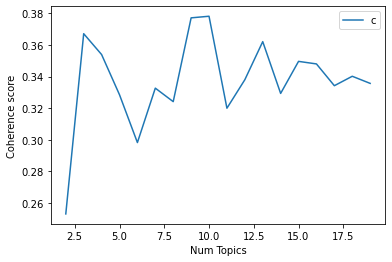

In [16]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [17]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2532
Num Topics = 3  has Coherence Value of 0.3671
Num Topics = 4  has Coherence Value of 0.3539
Num Topics = 5  has Coherence Value of 0.3285
Num Topics = 6  has Coherence Value of 0.2983
Num Topics = 7  has Coherence Value of 0.3327
Num Topics = 8  has Coherence Value of 0.3241
Num Topics = 9  has Coherence Value of 0.3771
Num Topics = 10  has Coherence Value of 0.3781
Num Topics = 11  has Coherence Value of 0.32
Num Topics = 12  has Coherence Value of 0.338
Num Topics = 13  has Coherence Value of 0.362
Num Topics = 14  has Coherence Value of 0.3293
Num Topics = 15  has Coherence Value of 0.3496
Num Topics = 16  has Coherence Value of 0.348
Num Topics = 17  has Coherence Value of 0.3342
Num Topics = 18  has Coherence Value of 0.3402
Num Topics = 19  has Coherence Value of 0.3357


In [20]:
ldamodel = LdaModel(corpus=corpus, num_topics=2, id2word=dictionary)

In [21]:
ldamodel.show_topics(10)

[(0,
  '0.052*"dioxide" + 0.040*"coronavirus" + 0.034*"be" + 0.031*"nitrogen" + 0.020*"show" + 0.020*"pollution" + 0.016*"satellite" + 0.015*"level" + 0.012*"drop" + 0.012*"emission"'),
 (1,
  '0.055*"be" + 0.033*"dioxide" + 0.019*"nitrogen" + 0.019*"coronavirus" + 0.017*"have" + 0.015*"covid" + 0.014*"emission" + 0.012*"show" + 0.012*"satellite" + 0.011*"outbreak"')]

The Below Section is finding Document Topics Percentage and corresponding examples for each Document.

Run this section after getting the hightest coherence value for number of topic

In [22]:
document_topic = ldamodel.get_document_topics(bow=corpus, minimum_probability=None, minimum_phi_value=None, per_word_topics=False)

In [23]:
###Creating Topic ID List from ldamodel document topic and find the percentage for each topic#####
topicid_list = [] 
topicid_value = []
for i in document_topic:
    topic_value_list = []
    topic_index_list = []
    for j in i:
        topic_value_list.append(j[1])
        topic_index_list.append(j[0])
    max_value_index = topic_value_list.index(max(topic_value_list))   
    topicid_list.append(topic_index_list[max_value_index])  
    topicid_value.append(max(topic_value_list))
    
#print(topicid_value)
#print(len(topicid_list))
topic_count = {i:topicid_list.count(i) for i in topicid_list}
topic_percentage = {i:topic_count[i]*100/len(document_topic) for i in topic_count}
print(topic_percentage)

{1: 34.846192637418056, 0: 65.15380736258194}


In [25]:
topic_id = 0
value_list = []
index_list = []
dates_new = []
index_count= 0

for i in topicid_list:
    if (i==topic_id):
        value_list.append(topicid_value[index_count])
        index_list.append(index_count)
        dates_new.append(data.created_at[index_count].date().strftime("%Y/%m/%d"))
    index_count = index_count + 1
print(len(index_list))
print(dates_new)

1292
['2020/12/28', '2020/12/27', '2020/12/12', '2020/12/12', '2020/12/11', '2020/12/11', '2020/12/11', '2020/12/11', '2020/11/25', '2020/11/25', '2020/11/17', '2020/11/11', '2020/10/23', '2020/10/10', '2020/09/29', '2020/09/27', '2020/09/17', '2020/09/13', '2020/09/02', '2020/09/01', '2020/08/30', '2020/08/23', '2020/08/21', '2020/07/27', '2020/07/25', '2020/07/20', '2020/07/17', '2020/07/17', '2020/07/17', '2020/07/17', '2020/07/17', '2020/07/17', '2020/07/16', '2020/07/13', '2020/07/01', '2020/06/30', '2020/06/30', '2020/06/29', '2020/06/27', '2020/06/18', '2020/06/17', '2020/06/15', '2020/06/13', '2020/06/12', '2020/06/12', '2020/06/03', '2020/06/02', '2020/06/02', '2020/05/27', '2020/05/27', '2020/05/27', '2020/05/27', '2020/05/26', '2020/05/26', '2020/05/22', '2020/05/22', '2020/05/21', '2020/05/21', '2020/05/20', '2020/05/20', '2020/05/17', '2020/05/15', '2020/05/15', '2020/05/14', '2020/05/14', '2020/05/14', '2020/05/13', '2020/05/13', '2020/05/13', '2020/05/12', '2020/05/12', 

In [49]:
df_value = pd.DataFrame({'index':index_list,'value': value_list})
df_top_value = df_value.nlargest(1000, 'value')
df_top_value.reset_index(drop=True, inplace=True)

example_text = []
for i in range(len(df_top_value)):
    index_number = df_top_value['index'][i]
    example_text.append(data.text[index_number])
print(example_text)

["@AnushakaBajaj @DChaurasia2312 Yes many proofs read Covid 1981 book. it's available on online and pdf both. I can give u also.\nbut u or any other person   no proof scientifically to proof\nCORONA is totally Fraud to vacvinate people meanwhile for many deceases \nno need any Vax  c 95 % ppl already recovered", '#aevl_us  \nSo this #police #brutality, thing, is #staged. #Covid-19 is a scam. 2 Reasons.\nPush for so we will live like, " #ReadyPlayerOne " " Wall-E " " A-I "  " The Simpsons S23E09 excerpt: (Cashless Society) " \nThink about it, this is one, #Google "M...  ', '@OgLakyn These people need to watch this simplified video on how it works. Made a video that explains to kids (and adults) how the Corona Vaccine works (illustrated with The Simpsons)  ', "@Karamo In an attempt to explain to kids (and adults) how the Corona Vaccine works I made this video (illustrated with The Simpsons)   - If you'd like you can share it with your followers. Thanks.", "@gyasiwa_ Hi! In an attempt to 